i.

### SHRED applied to SST dataset

This iPython notebook gives an introductory walkthrough to using SHRED models.  The dataset we consider is weekly mean sea-surface temperature as given by the NOAA Optimum Interpolation SST V2 dataset (https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html).

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as 
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

We first randomly select 3 sensor locations and set the trajectory length (lags) to 52, corresponding to one year of measurements.

In [ ]:
import numpy as np
from processdata import load_data, TimeSeriesDataset
import models
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.io import loadmat

num_sensors = 3 
lags = 52
load_X = load_data('SST')
n = load_X.shape[0]
m = load_X.shape[1]
sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

ii.

We now select indices to divide the data into training, validation, and test sets.

In [ ]:
train_indices = np.random.choice(n - lags, size=1000, replace=False)
mask = np.ones(n - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[::2]
test_indices = valid_test_indices[1::2]

sklearn's MinMaxScaler is used to preprocess the data for training and we generate input/output pairs for the training, validation, and test sets. 

In [ ]:
sc = MinMaxScaler()
sc = sc.fit(load_X[train_indices])
transformed_X = sc.transform(load_X)

### Generate input sequences to a SHRED model
all_data_in = np.zeros((n - lags, lags, num_sensors))
for i in range(len(all_data_in)):
    all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

### -1 to have output be at the same time as final sensor measurements
train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

We train the model using the training and validation datasets.

In [ ]:
shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=1000, lr=1e-3, verbose=True, patience=5)

epoch: 760 valid_error: tensor(0.1164):  76%|███████▌  | 759/1000 [1:11:58<22:51,  5.69s/it]


Finally, we generate reconstructions from the test set and print mean square error compared to the ground truth.

In [ ]:
test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
print(np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

0.019834021


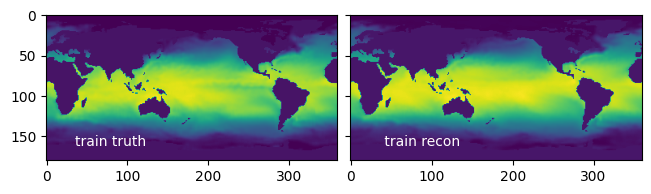

In [ ]:
train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())

from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()
full_train_truth = full_SST[train_indices, :]

# replacing SST data with our reconstruction
full_train_recon = full_train_truth.copy()
full_train_recon[:,sst_locs] = train_recons

# reshaping to 2d frames
for x in [full_train_truth, full_train_recon]:
    x.resize(len(x),180,360)
  
plotdata = [full_train_truth, full_train_recon]
labels = ['train truth',' train recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)

for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes) 

Plot a sample test frame and its reconstruction.

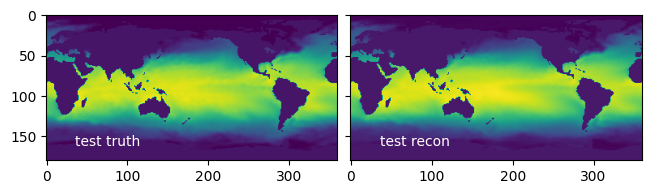

In [ ]:
full_test_truth = full_SST[test_indices, :]

# replacing SST data with our reconstruction
full_test_recon = full_test_truth.copy()
full_test_recon[:,sst_locs] = test_recons

# reshaping to 2d frames
for x in [full_test_truth, full_test_recon]:
    x.resize(len(x),180,360)

plotdata = [full_test_truth, full_test_recon]
labels = ['test truth','test recon']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

iii.

In [ ]:
n_lags = np.arange(1,21) * 5
error = np.zeros(20)

from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()


FST = []
FSR = []
print(n_lags)

[  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100]


In [ ]:
for j in range(len(n_lags)):
  l = n_lags[j]
  sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

  train_indices = np.random.choice(n - l, size=1000, replace=False)
  mask = np.ones(n - l)
  mask[train_indices] = 0
  valid_test_indices = np.arange(0, n - l)[np.where(mask!=0)[0]]
  valid_indices = valid_test_indices[::2]
  test_indices = valid_test_indices[1::2] 

  sc = MinMaxScaler()
  sc = sc.fit(load_X[train_indices])
  transformed_X = sc.transform(load_X)

  ### Generate input sequences to a SHRED model
  all_data_in = np.zeros((n - l, l, num_sensors))
  for i in range(len(all_data_in)):
      all_data_in[i] = transformed_X[i:i+l, sensor_locations]

  ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
  valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
  test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

  ### -1 to have output be at the same time as final sensor measurements
  train_data_out = torch.tensor(transformed_X[train_indices + l - 1], dtype=torch.float32).to(device)
  valid_data_out = torch.tensor(transformed_X[valid_indices + l - 1], dtype=torch.float32).to(device)
  test_data_out = torch.tensor(transformed_X[test_indices + l - 1], dtype=torch.float32).to(device)

  train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
  valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
  test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

  shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
  validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

  test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
  test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
  error[j] = (np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

  full_test_truth = full_SST[test_indices, :]

  # replacing SST data with our reconstruction
  full_test_recon = full_test_truth.copy()
  full_test_recon[:,sst_locs] = test_recons

  # reshaping to 2d frames
  for x in [full_test_truth, full_test_recon]:
      x.resize(len(x),180,360)

  FST.append(full_test_truth)
  FSR.append(full_test_recon)
print(error)

epoch: 100 valid_error: tensor(0.2125): 100%|██████████| 100/100 [10:52<00:00,  6.52s/it]


[0.0361104  0.04098316 0.03420468 0.04067857 0.03547319 0.03579105
 0.03536259 0.0364052  0.03382064 0.03443923 0.03498938 0.03497679
 0.03382722 0.03550398 0.03622158 0.03297274 0.03534422 0.0348957
 0.0348001  0.03617669]


Text(0, 0.5, 'MSE Error')

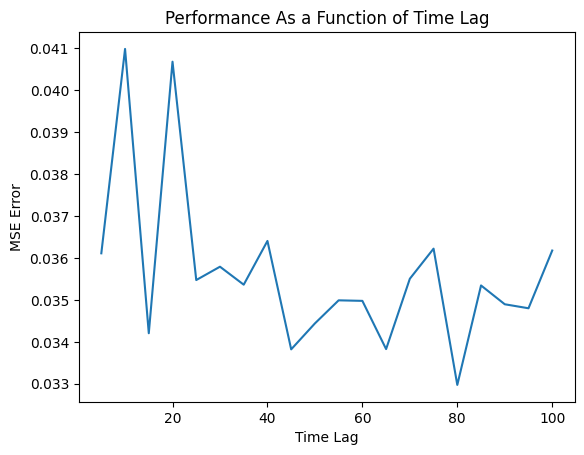

In [ ]:
plt.plot(n_lags, error)
plt.title('Performance As a Function of Time Lag')
plt.xlabel('Time Lag')
plt.ylabel('MSE Error')

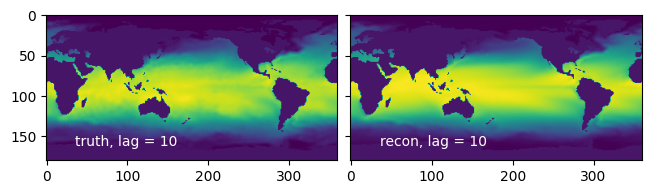

In [ ]:
plotdata = [FST[2-1], FSR[2-1]]
labels = ['truth, lag = 10','recon, lag = 10']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

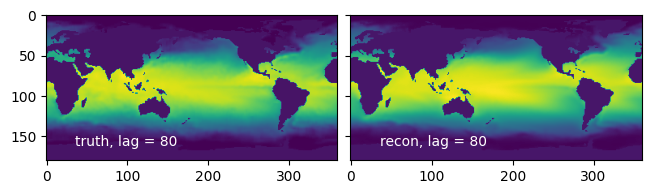

In [ ]:
plotdata = [FST[16-1], FSR[16-1]]
labels = ['truth, lag = 80','recon, lag = 80']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

iv.

In [ ]:
print(np.min(load_X))
print(np.max(load_X))

-1.7999999597668648
35.62999920360744


In [ ]:
n_noise = np.arange(0,20) / 10
error = np.zeros(20)

from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()


FST = []
FSR = []
print(n_noise)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9]


In [ ]:
for j in range(len(n_noise)):
  noise = n_noise[j] * np.random.normal(size=load_X.shape)

  sensor_locations = np.random.choice(m, size=num_sensors, replace=False)

  train_indices = np.random.choice(n - lags, size=1000, replace=False)
  mask = np.ones(n - lags)
  mask[train_indices] = 0
  valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
  valid_indices = valid_test_indices[::2]
  test_indices = valid_test_indices[1::2] 

  sc = MinMaxScaler()
  sc = sc.fit(load_X[train_indices])
  transformed_X = sc.transform(load_X + noise)

  ### Generate input sequences to a SHRED model
  all_data_in = np.zeros((n - lags, lags, num_sensors))
  for i in range(len(all_data_in)):
      all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

  ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
  valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
  test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

  ### -1 to have output be at the same time as final sensor measurements
  train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
  valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
  test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

  train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
  valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
  test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

  shred = models.SHRED(num_sensors, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
  validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

  test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
  test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
  error[j] = (np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

  full_test_truth = full_SST[test_indices, :]

  # replacing SST data with our reconstruction
  full_test_recon = full_test_truth.copy()
  full_test_recon[:,sst_locs] = test_recons

  # reshaping to 2d frames
  for x in [full_test_truth, full_test_recon]:
      x.resize(len(x),180,360)

  FST.append(full_test_truth)
  FSR.append(full_test_recon)
print(error)

epoch: 100 valid_error: tensor(1.0148):  99%|█████████▉| 99/100 [13:56<00:08,  8.45s/it]


[0.03517034 0.03779124 0.04210107 0.05053921 0.0511667  0.06396063
 0.06459565 0.11376303 0.08130861 0.08718303 0.10514929 0.10887528
 0.13379285 0.15401411 0.15269114 0.11368763 0.13784544 0.15295084
 0.23398556 0.22504255]


Text(0, 0.5, 'MSE Error')

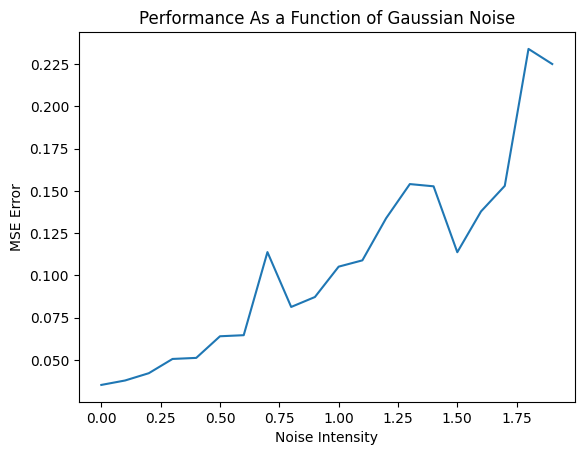

In [ ]:
plt.plot(n_noise, error)
plt.title('Performance As a Function of Gaussian Noise')
plt.xlabel('Noise Intensity')
plt.ylabel('MSE Error')

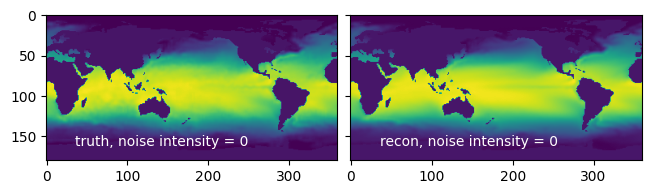

In [ ]:
plotdata = [FST[1-1], FSR[1-1]]
labels = ['truth, noise intensity = 0','recon, noise intensity = 0']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

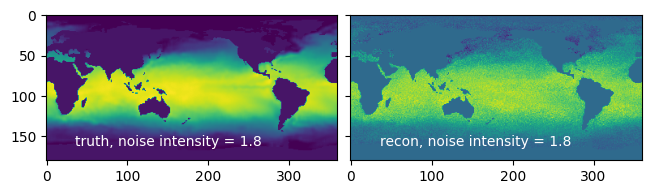

In [ ]:
plotdata = [FST[19-1], FSR[19-1]]
labels = ['truth, noise intensity = 1.8','recon, noise intensity = 1.8']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

v.

In [ ]:
n_sensors = np.arange(1,21)
error = np.zeros(20)

from processdata import load_full_SST

# SST data with world map indices for plotting
full_SST, sst_locs = load_full_SST()


FST = []
FSR = []
print(n_sensors)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [ ]:
for j in range(len(n_sensors)):
  sensor_locations = np.random.choice(m, size=j, replace=False)

  train_indices = np.random.choice(n - lags, size=1000, replace=False)
  mask = np.ones(n - lags)
  mask[train_indices] = 0
  valid_test_indices = np.arange(0, n - lags)[np.where(mask!=0)[0]]
  valid_indices = valid_test_indices[::2]
  test_indices = valid_test_indices[1::2] 

  sc = MinMaxScaler()
  sc = sc.fit(load_X[train_indices])
  transformed_X = sc.transform(load_X)

  ### Generate input sequences to a SHRED model
  all_data_in = np.zeros((n - lags, lags, j))
  for i in range(len(all_data_in)):
      all_data_in[i] = transformed_X[i:i+lags, sensor_locations]

  ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
  valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
  test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

  ### -1 to have output be at the same time as final sensor measurements
  train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
  valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
  test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

  train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
  valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
  test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

  shred = models.SHRED(j, m, hidden_size=64, hidden_layers=2, l1=350, l2=400, dropout=0.1).to(device)
  validation_errors = models.fit(shred, train_dataset, valid_dataset, batch_size=64, num_epochs=100, lr=1e-3, verbose=True, patience=5)

  test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
  test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
  error[j] = (np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth))

  full_test_truth = full_SST[test_indices, :]

  # replacing SST data with our reconstruction
  full_test_recon = full_test_truth.copy()
  full_test_recon[:,sst_locs] = test_recons

  # reshaping to 2d frames
  for x in [full_test_truth, full_test_recon]:
      x.resize(len(x),180,360)

  FST.append(full_test_truth)
  FSR.append(full_test_recon)
print(error)

epoch: 100 valid_error: tensor(0.1694): 100%|██████████| 100/100 [10:01<00:00,  6.02s/it]


[0.10754386 0.03667126 0.03553595 0.03397719 0.03590523 0.03125491
 0.03186118 0.03109765 0.03234163 0.03243086 0.03171523 0.03096646
 0.03136846 0.03101325 0.02962463 0.03075942 0.03062579 0.03155619
 0.03072381 0.03073814]


Text(0, 0.5, 'MSE Error')

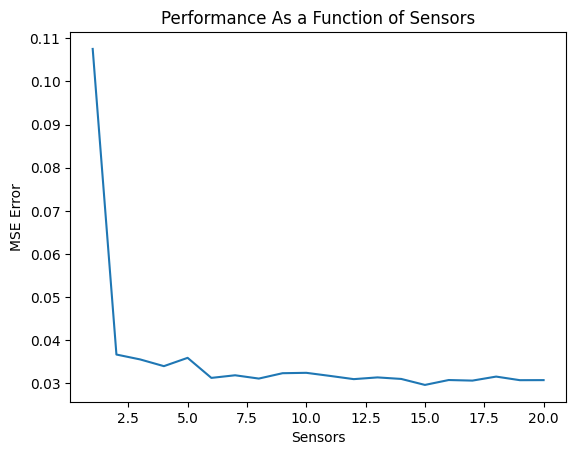

In [ ]:
plt.plot(n_sensors, error)
plt.title('Performance As a Function of Sensors')
plt.xlabel('Sensors')
plt.ylabel('MSE Error')

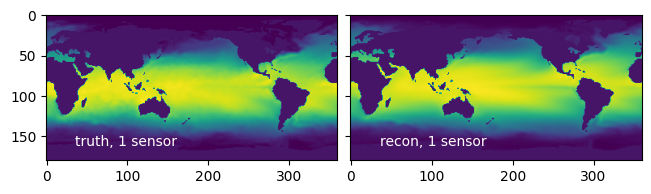

In [ ]:
plotdata = [FST[1-1], FSR[1-1]]
labels = ['truth, 1 sensor','recon, 1 sensor']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)

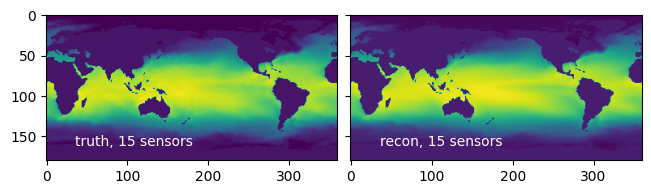

In [ ]:
plotdata = [FST[15-1], FSR[15-1]]
labels = ['truth, 15 sensors','recon, 15 sensors']
fig, ax = plt.subplots(1,2,constrained_layout=True,sharey=True)
for axis,p,label in zip(ax, plotdata, labels):
    axis.imshow(p[0])
    axis.set_aspect('equal')
    axis.text(0.1,0.1,label,color='w',transform=axis.transAxes)